In [16]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy as dup
from scipy.integrate import solve_ivp

# My modules
import diffusionstuff10 as ds

In [17]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2

### The cell below specifies parameters for the 0-d and 1-d runs

<IPython.core.display.Javascript object>


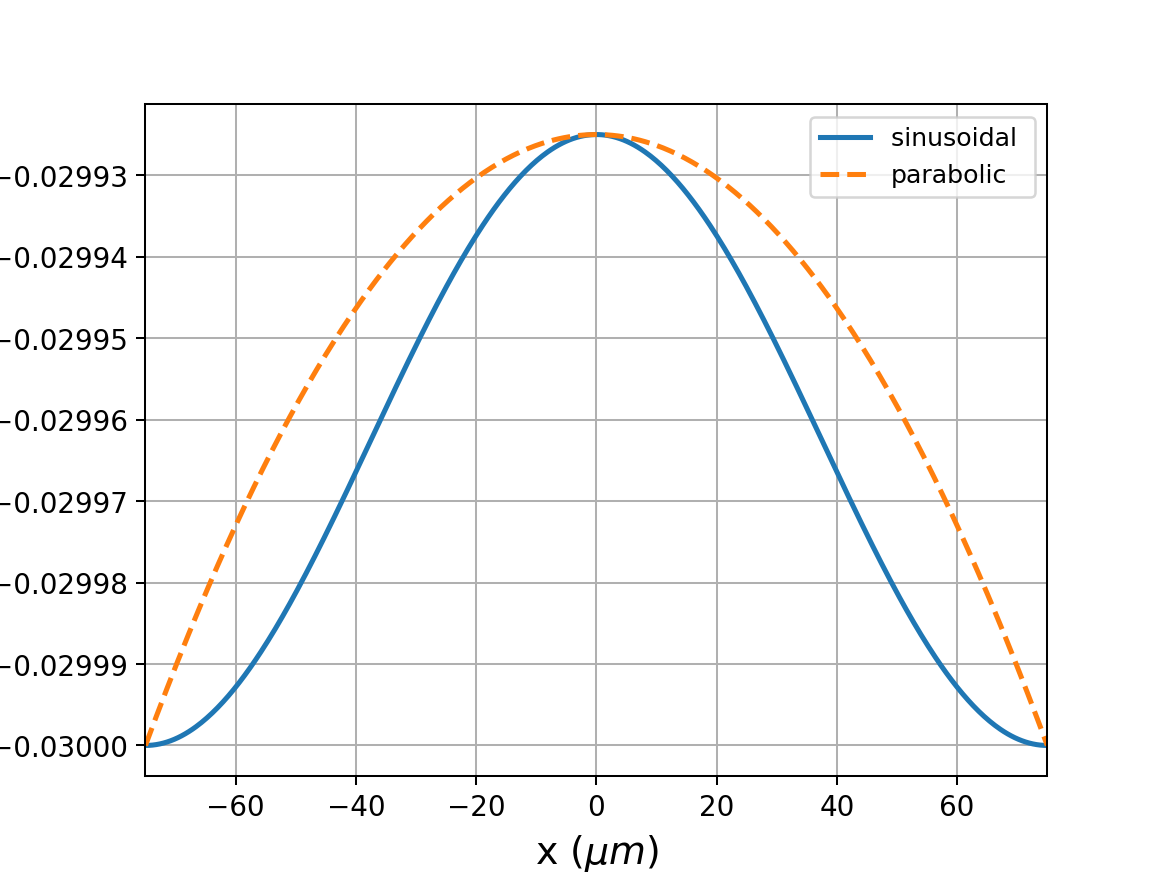

nu_kin_mlyperus = 0.11333333333333333 monolayers/us
nmid = 250
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.3
sigma_0 = 0.19
sigmaIcorner = -0.03
center reduction = 0.25 %
c_r = 0.0025 dimensionless
max growth rate = -1.02 um/sec
min growth rate = -7.4799999999999995 um/sec
nu_kin = 34 um/sec
dx = 0.3
L = 75.0 micrometers
nx = 501
tau_eq = 1 microseconds
corner supersaturation (%) = -115.78947368421053


In [18]:
#Setting up the system
nx = 501; xmax = 150
# nx = 801; xmax = 150*nx/501
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
nmid = int(nx/2)
xmid = max(x)/2
xmax = x[nx-1]
L = xmax/2
# tau_eq = 3
tau_eq = 1

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 1e-3 # micrometers^2/microsecond
# D = 5e-4 # micrometers^2/microsecond
# D = 2e-4 # micrometers^2/microsecond
# D = 1.6e-4 # micrometers^2/microsecond
# D = 1e-4 # micrometers^2/microsecond
# D = 2e-5 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond
Doverdeltax2 = D/deltax**2

# Deposition rate
# nu_kin = 20 # microns/second - about right for 240 K
nu_kin = 34 # microns/second - about right for 240 K
# nu_kin = 49 # microns/second - between 240 and 260 K
# nu_kin = 75 # microns/second - between 240 and 260 K
# nu_kin = 80 # microns/second - between 240 and 260 K
# nu_kin = 90 # microns/second - between 240 and 260 K
# nu_kin = 100 # microns/second - between 240 and 260 K
# nu_kin = 150 # microns/second - between 240 and 260 K
# nu_kin = 250 # microns/second - about right for 260 K
nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
sigma0 = 0.19
# sigmaIcorner = -0.5 # Must be bigger than sigma0 to get growth (unstable)
# sigmaIcorner = -0.45 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.4 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.3 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.2 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.1 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.05 # Must be bigger than sigma0 to get growth
sigmaIcorner = -0.03 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.02 # Must be bigger than sigma0 to get growth
# sigmaIcorner = -0.01 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.18 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.191 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.192 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.193 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.194 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.195 # Must be bigger than sigma0 to get growth (unstable)
# sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.21 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.22 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.23 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.25 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.275 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.3 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.4 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.6 # Must be bigger than sigma0 to get growth
# sigmaIcorner = 0.9 # Must be bigger than sigma0 to get growth 

center_reduction = 0.25 # In percent
# center_reduction = 0.5 # In percent
# center_reduction = .1 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time step and space step

# Overlying supersaturation
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
# sigmaIstyle = 'sinusoid'
sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')
plt.figure()
# plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
#          x-xmid, sigmaI_parabolic/sigmaIcorner, '--',lw=linewidth)
plt.plot(x-xmid,sigmaI_sinusoid, \
         x-xmid, sigmaI_parabolic, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

# Integrator
# odemethod ='Radau' # much too slow (implicit)
# odemethod ='BDF' # still slow (implicit), faster than Radau, results closest to DOP853 and LSODA
# odemethod ='DOP853' # slowest of explicit methods
odemethod ='LSODA' # results are a lot like DOP853, but faster
# odemethod ='RK45' # faster, but results look different from LSODA
# odemethod ='RK23' # fastest, produces V-shaped profiles

# Reporting
print('nu_kin_mlyperus =', nu_kin_mlyperus, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', nu_kin_mlyperus*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', nu_kin_mlyperus*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')
print("nx =", nx)
print('tau_eq =', tau_eq, 'microseconds')
print('corner supersaturation (%) =', (sigmaIcorner-sigma0)/sigma0*100)

### This is the 0-d run

In [19]:
# Time steps
ntimes = 200
tlast = 4000
tkeep_0Darr = np.linspace(0,tlast,ntimes)

# Bundle parameters for ODE solver
params = np.array([Nbar, Nstar, sigmaIcorner, sigma0, nu_kin_mlyperus, tau_eq])

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_0D = 0
NQLL_init_0D = ds.getNQLL(Ntot_init_0D,Nstar,Nbar)

# Solve
Ntotkeep_0D, NQLLkeep_0D = ds.run_f0d(NQLL_init_0D,Ntot_init_0D,tkeep_0Darr,params,odemethod)
Nicekeep_0D = Ntotkeep_0D - NQLLkeep_0D

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


### Analysis of the 0-d run

0-D Modeled growth rate, um/s -2.4664099813281415
0-D Modeled growth rate, ml/us -0.008221366604427138
0-D Modeled alpha 2.4180490013020997


<IPython.core.display.Javascript object>


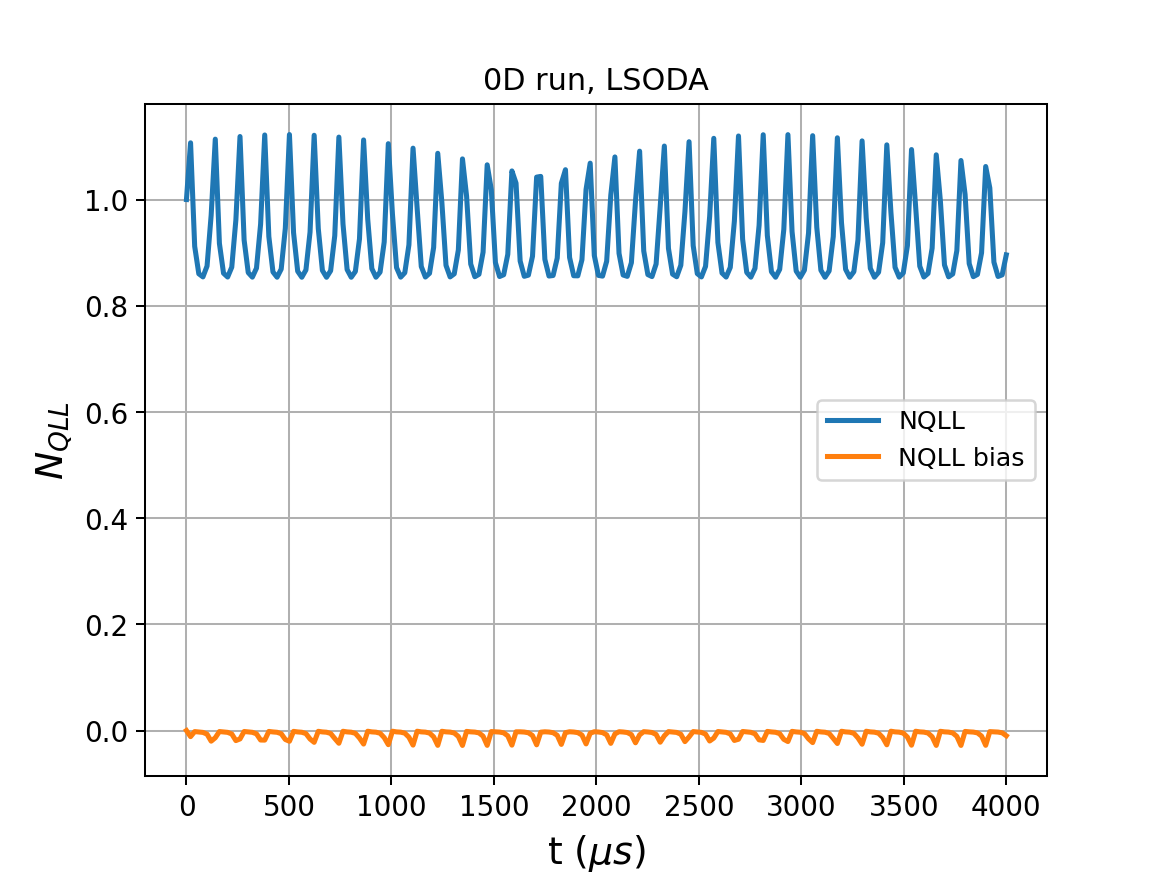

In [20]:
# Growth statistics
delta_Ntot_0D = Ntotkeep_0D[-1]-Ntot_init_0D
growthrate_0D_mlyperus = delta_Ntot_0D/tkeep_0Darr[-1] # monolayer/us
growthrate_0D = growthrate_0D_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0D)
print( "0-D Modeled growth rate, ml/us", growthrate_0D_mlyperus)
alpha_0D = growthrate_0D/nu_kin/sigmaIcorner
print( "0-D Modeled alpha", alpha_0D)
title = '0D run, '+odemethod

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0Darr,NQLLkeep_0D,lw=linewidth,label='NQLL')
plt.plot(tkeep_0Darr,NQLLkeep_0D-ds.getNQLL(Ntotkeep_0D,Nstar,Nbar),lw=linewidth,label='NQLL bias')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.title(title)
plt.legend()

### This is the 1-d run

In [21]:
# Time steps
ntimes = 400
tlast = 1500000
tkeep_1Darr = np.linspace(0,tlast,ntimes)
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

# Bundle parameters for ODE solver
scalar_params = np.array([Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq])

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)
NQLL_init_1D = ds.getNQLL(Ntot_init_1D,Nstar,Nbar)

# Solve
Ntotkeep_1D, NQLLkeep_1D = ds.run_f1d(NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,scalar_params,sigmaI,odemethod)
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

dt = 3759.3984962406016
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done


### Analysis of the 1-d run

1-D growth rate, ml/us -0.008212448186831856
1-D growth rate, um/s -2.463734456049557
1-D alpha 2.4154259373034876
Analysis of growth rates relative to 0D system
    1D, 0D alpha = 2.4154259373034876 2.4180490013020997
    1D ablation is slower by: 0.1 %
Libbrecht's predicted growth rate -4.110331236774811 um/s
Libbrecht's predicted alpha 4.029736506641972
horizontal layer speed (micrometers/microsecond) = -0.6159336140123892


<IPython.core.display.Javascript object>


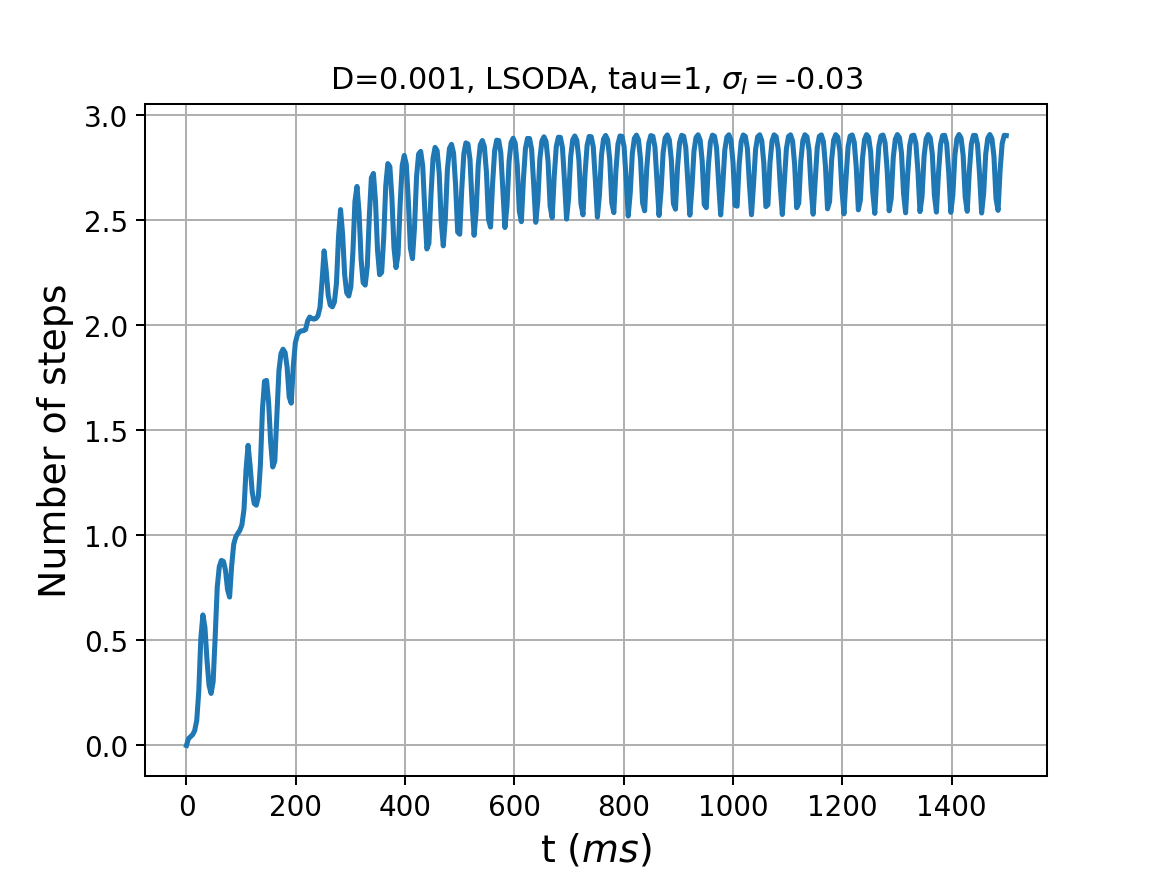

nsteps average of last 30.0 % ( 120 points) = 2.7721688042183508
estimated lambda = 27.05462953261507
estimated layer residence time (microseconds) = -43.92458686638732


<IPython.core.display.Javascript object>


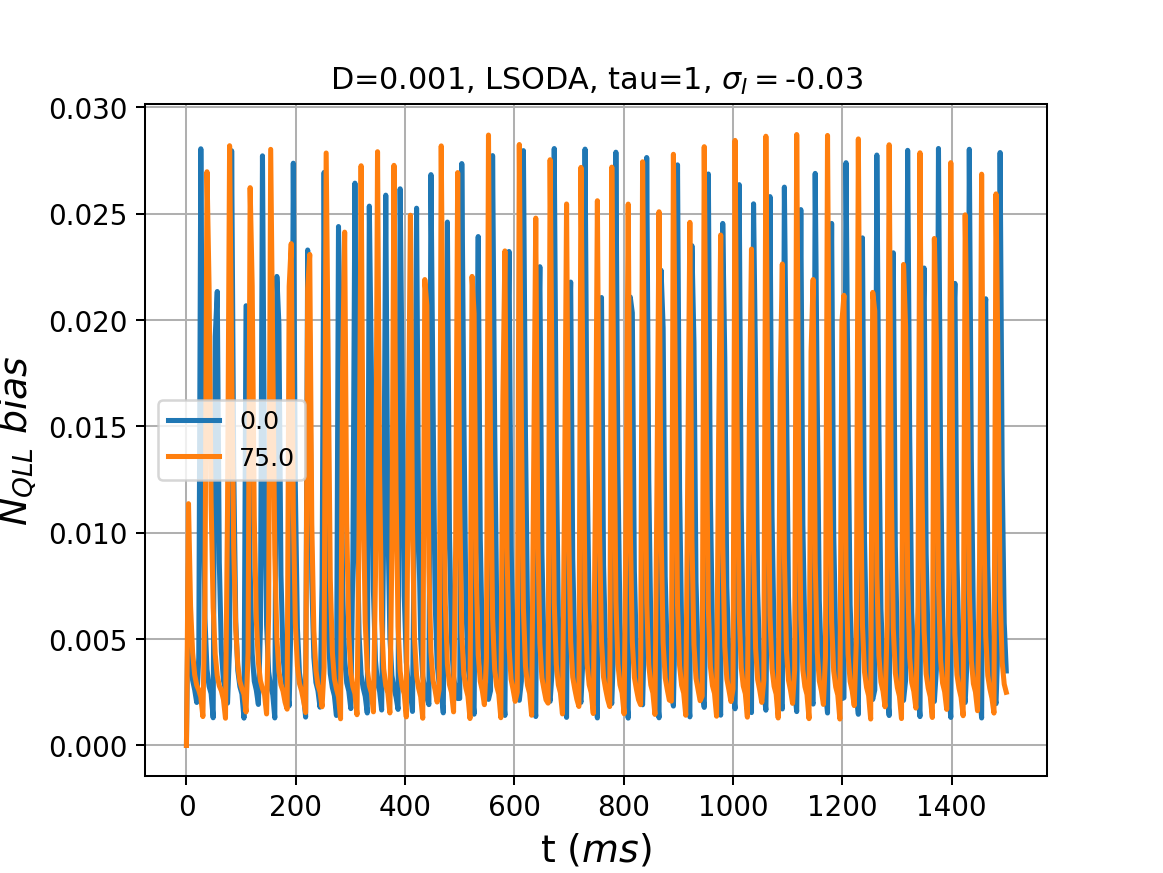

<IPython.core.display.Javascript object>


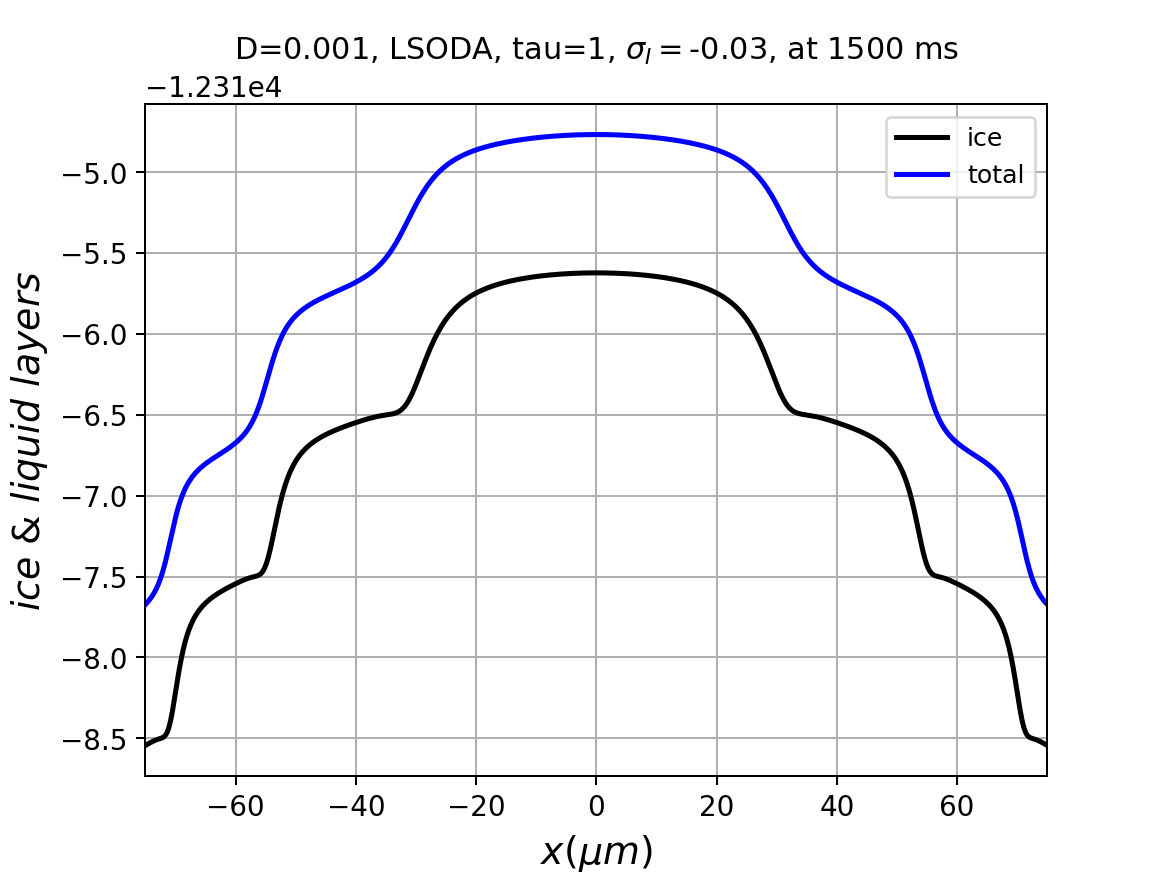

<IPython.core.display.Javascript object>


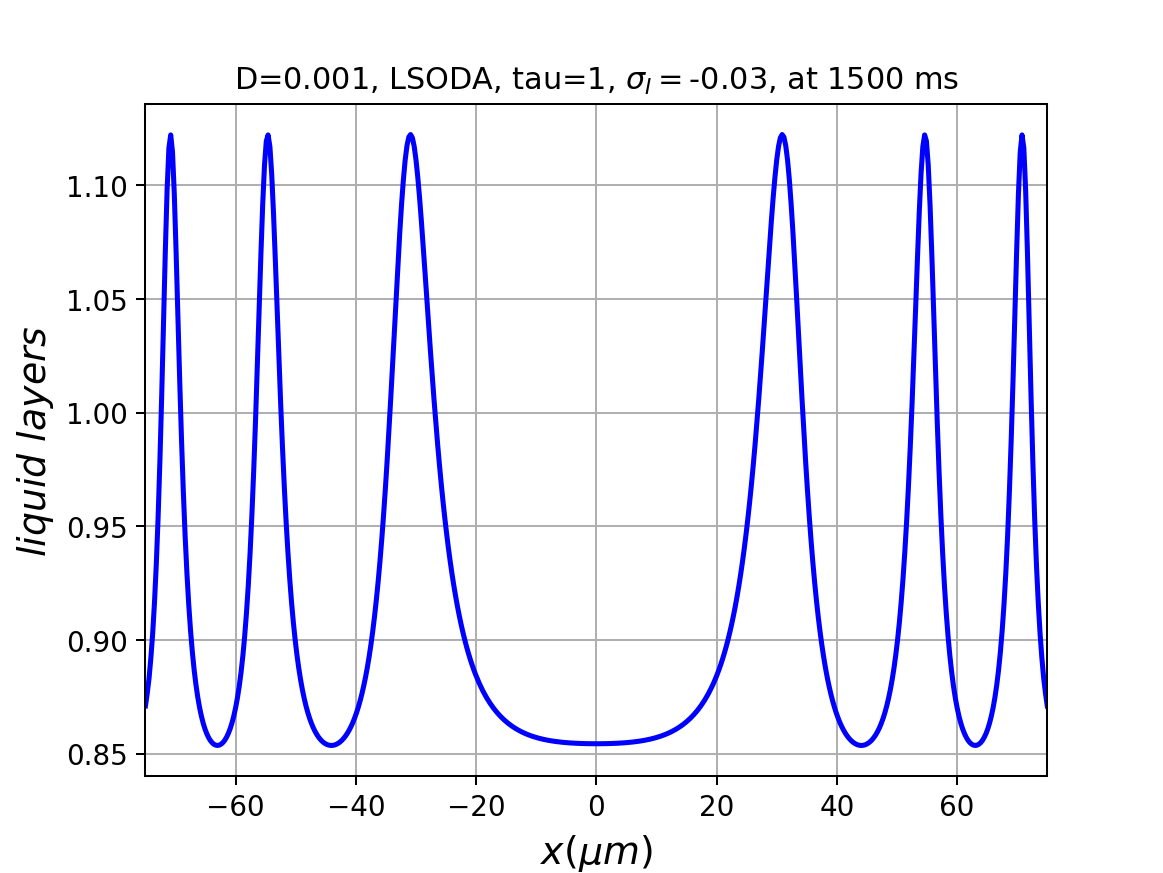

In [22]:
# Stats
delta_Ntot_1D = Ntotkeep_1D[-1,0]-Ntotkeep_1D[0,0]
growthrate_1D_mlyperus = delta_Ntot_1D/tlast; print( "1-D growth rate, ml/us", growthrate_1D_mlyperus)
growthrate_1D = growthrate_1D_mlyperus*umpersec_over_mlyperus; print( "1-D growth rate, um/s", growthrate_1D)
alpha_1D = growthrate_1D/nu_kin/sigmaIcorner; print( "1-D alpha", alpha_1D)
delta_alpha = (alpha_1D-alpha_0D)/alpha_0D*100; 
print('Analysis of growth rates relative to 0D system')
print("    1D, 0D alpha =", alpha_1D, alpha_0D)
if delta_Ntot_1D > 0: # Growing
    if delta_alpha < 0:
        print("    1D growth is slower by:", -int(delta_alpha*100)/100,'%')
    else:
        print("    1D growth is faster by:", int(delta_alpha*100)/100,'%')
else: # Ablating
    if delta_alpha < 0:
        print("    1D ablation is slower by:", -int(delta_alpha*100)/100,'%')
    else:
        print("    1D ablation is faster by:", int(delta_alpha*100)/100,'%')

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate", nu_kin*alpha_L*sigmaIcorner, "um/s")
print("Libbrecht's predicted alpha", alpha_L)

# Horizontal speed of layers
HLS = growthrate_1D_mlyperus*L
print('horizontal layer speed (micrometers/microsecond) =',HLS)

# Other statistics prep
lastfraction = 0.3

# Graphics prep
title = 'D='+str(D)+', '+odemethod + ', tau='+str(tau_eq)+', $\sigma_I=$'+str(sigmaIcorner)

# # Plot number of steps over time (with index on the x-axis)
# plt.figure()
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
# plt.plot(f,lw=linewidth)
# plt.xlabel('index',fontsize=fontsize)
# plt.ylabel('Number of steps',fontsize=fontsize)
# plt.title(title)
# plt.grid('on')
# # plt.xlim([550,620])

# Plot number of steps over time
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
plt.plot(tkeep_1Darr/1e3,f,lw=linewidth)
plt.xlabel(r't ($m s$)',fontsize=fontsize)
plt.ylabel('Number of steps',fontsize=fontsize)
plt.title(title)
plt.grid('on')
itimes_almost_end = int(ntimes*(1-lastfraction))
nsteps_ss = np.mean(f[itimes_almost_end:-1])
print('nsteps average of last', lastfraction*100, '% (', ntimes-itimes_almost_end, 'points) =', nsteps_ss)
lambda_average = L/nsteps_ss
print('estimated lambda =', lambda_average)
residence_time = lambda_average/HLS
print('estimated layer residence time (microseconds) =',residence_time)

# # Plot number of steps as vertical distance over time
# plt.figure()
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
# f *= nmpermonolayer
# plt.plot(tkeep_1Darr/1e3,f,lw=linewidth)
# plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
# plt.ylabel(r'vertical relief ($nm$)',fontsize=fontsize)
# plt.title(title)
# plt.grid('on')

# Plot NQLL over time
iposition1 = nmid; NQLL_in_equilibrium_with_Ntot_1 = ds.getNQLL(Ntotkeep_1D[:,iposition1],Nstar,Nbar)
iposition2 = -1;   NQLL_in_equilibrium_with_Ntot_2 = ds.getNQLL(Ntotkeep_1D[:,iposition2],Nstar,Nbar)
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_1Darr/1e3,NQLL_in_equilibrium_with_Ntot_1-NQLLkeep_1D[:,iposition1],lw=linewidth,label=str(x[iposition1]-xmid))
plt.plot(tkeep_1Darr/1e3,NQLL_in_equilibrium_with_Ntot_2-NQLLkeep_1D[:,iposition2],lw=linewidth,label=str(x[iposition2]-xmid))
# plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.xlabel(r't ($m s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} \ bias$',fontsize=fontsize)
plt.title(title)
plt.legend()
plt.grid('on')

# Plot ice and total
itime = -1
plt.figure()
plt.plot(x-xmid, Nicekeep_1D[itime,:], 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Ntotkeep_1D[itime,:], 'b', label='total', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title+', at '+str(int(tkeep_1Darr[itime]/1e3))+' ms')
plt.grid('on')

# Plot liquid
itime = -1
plt.figure()
plt.plot(x-xmid, NQLLkeep_1D[itime,:], 'b', label='liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.title(title+', at '+str(int(tkeep_1Darr[itime]/1e3))+' ms')
plt.grid('on')

### Perturbation 1
This takes the original flat state, runs it with a sinusoidal sigmaI, then does the specified sigmaI.

In [ ]:
Iwantperturbation1 = True
if Iwantperturbation1:
    
    mode = 4
    sign = np.sign(growthrate_0D)
    sigmaI_sinusoid = sign*np.cos((x-xmid)/xmid*np.pi*mode)*0.0002+sigmaI
    
    # Here's the first perturbation
    tlast_perturbed = tlast
    ntimes_perturbed = int(ntimes/tlast*tlast_perturbed)
    tkeep_perturbed = np.linspace(0,tlast_perturbed,ntimes_perturbed)
    print('dt =', tkeep_perturbed[1]-tkeep_perturbed[0])

    # Solve
    Ntotkeep_perturbed, NQLLkeep_perturbed = ds.run_f1d(NQLL_init_1D,Ntot_init_1D,tkeep_perturbed,scalar_params,sigmaI_sinusoid,odemethod)
    Nicekeep_perturbed = Ntotkeep_perturbed-NQLLkeep_perturbed

<IPython.core.display.Javascript object>


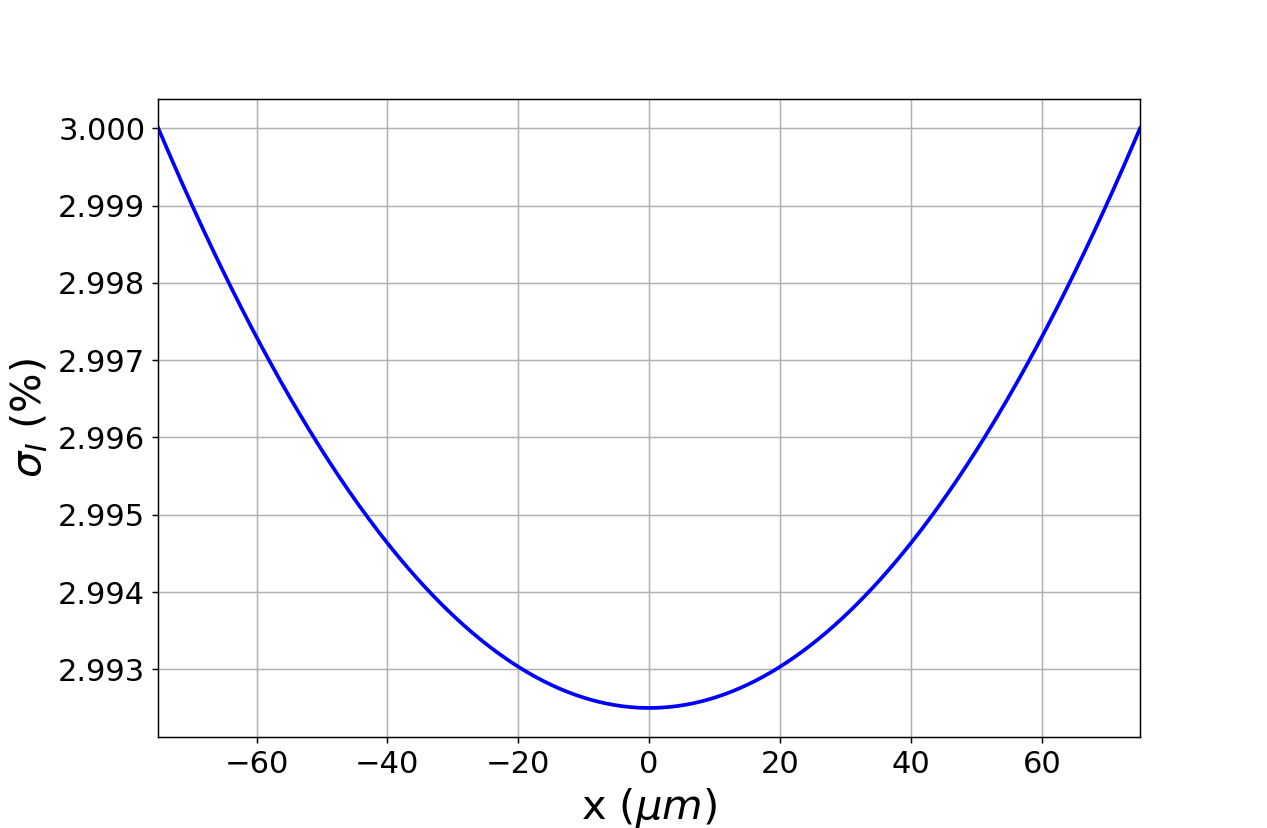

<IPython.core.display.Javascript object>


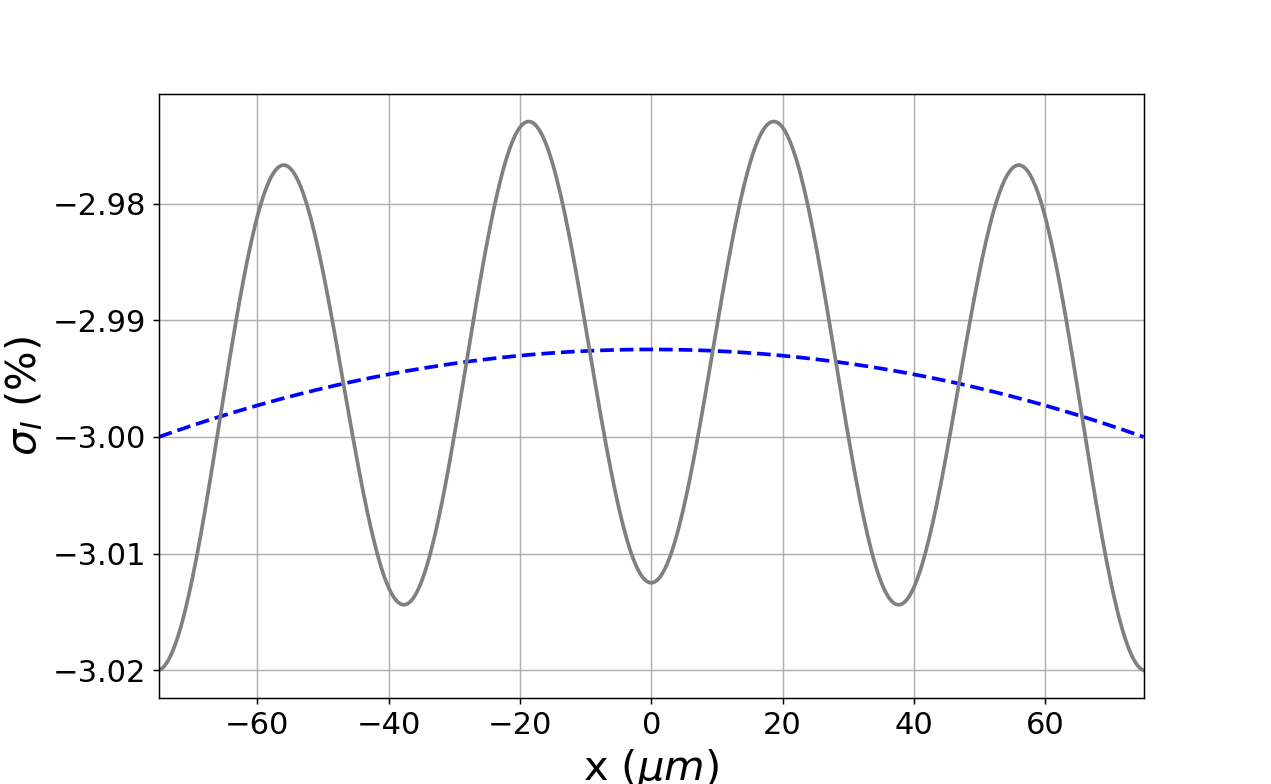

<IPython.core.display.Javascript object>


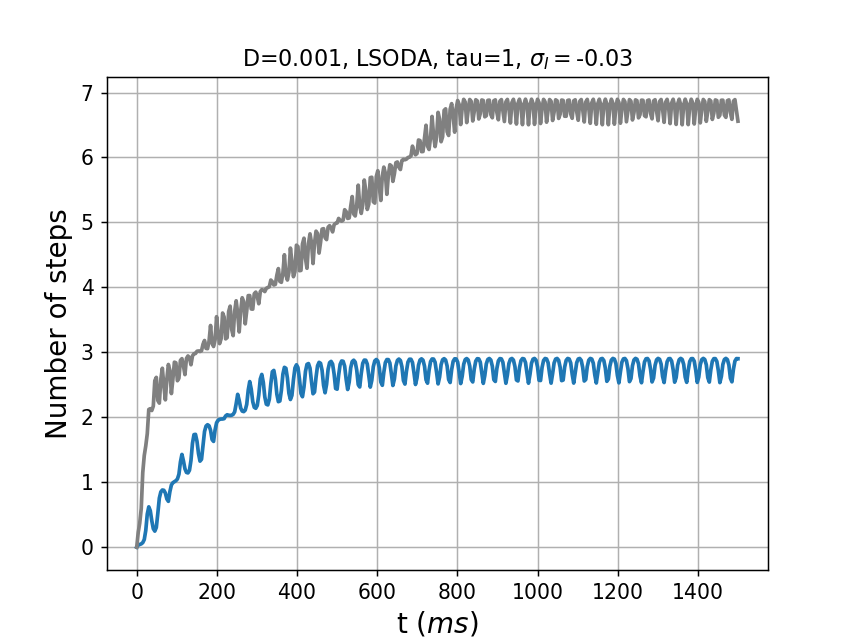

<IPython.core.display.Javascript object>


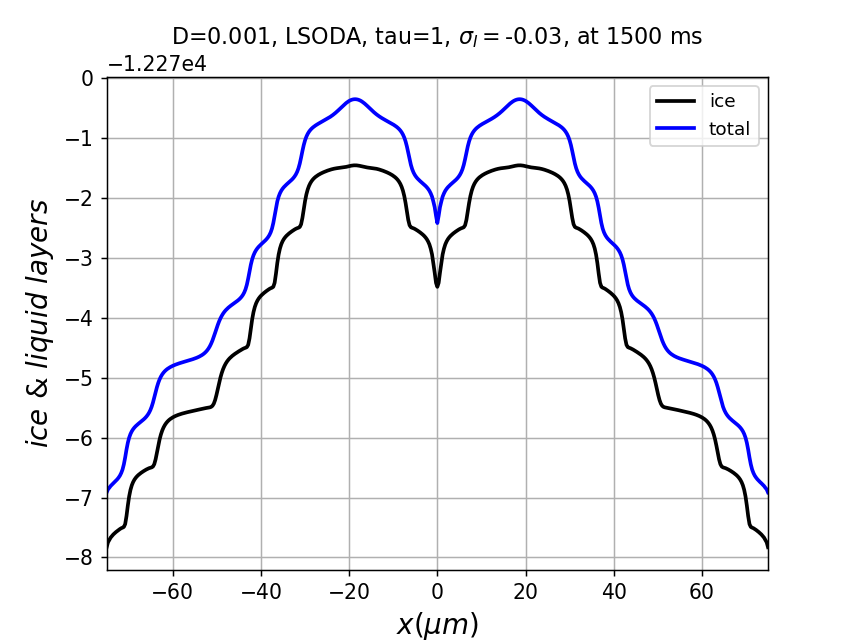

<IPython.core.display.Javascript object>


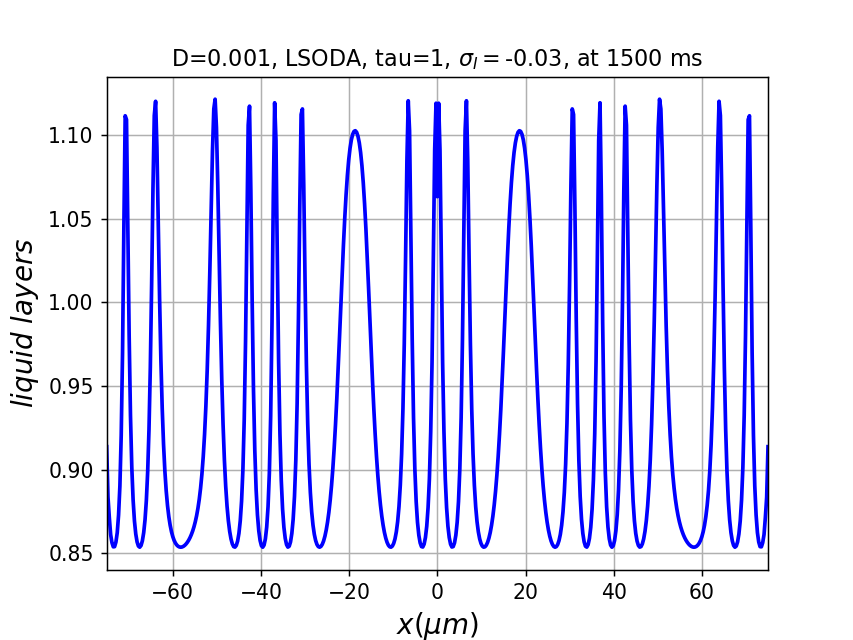

In [61]:
if Iwantperturbation1:
    
    # Plot the supersaturation profile
    sizemag = 1.5
    plt.figure()
    rcParams['xtick.labelsize'] = ticklabelsize*sizemag
    rcParams['ytick.labelsize'] = ticklabelsize*sizemag
    plt.plot(x-xmid,-sigmaI*100, 'b', lw=linewidth, label = 'supersaturated (growth) conditions')
    plt.xlim([-xmid,xmid])
    plt.xlabel(r'x ($\mu m$)',fontsize=fontsize*sizemag)
    plt.ylabel(r'$\sigma_I$ (%)',fontsize=fontsize*sizemag)
    plt.grid('on')

    plt.figure()
    rcParams['xtick.labelsize'] = ticklabelsize*sizemag
    rcParams['ytick.labelsize'] = ticklabelsize*sizemag
    plt.plot(x-xmid,sigmaI*100, 'b--', lw=linewidth, label = 'subsaturated (ablation) conditions')
    plt.plot(x-xmid,sigmaI_sinusoid*100, 'gray', label = 'sinusoidal perturbation', lw=linewidth)
    plt.xlim([-xmid,xmid])
    plt.xlabel(r'x ($\mu m$)',fontsize=fontsize*sizemag)
    plt.ylabel(r'$\sigma_I$ (%)',fontsize=fontsize*sizemag)
    plt.grid('on')

    # Plot number of steps over time
    plt.figure()
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    plt.plot(tkeep_1Darr/1e3,f,lw=linewidth)
    f = np.max(Ntotkeep_perturbed,axis=1) - np.min(Ntotkeep_perturbed,axis=1)
    plt.plot(tkeep_perturbed/1e3,f,lw=linewidth,color='gray')
    plt.xlabel(r't ($m s$)',fontsize=fontsize)
    plt.ylabel('Number of steps',fontsize=fontsize)
    plt.title(title)
    plt.grid('on')
    
    # Plot ice and total
    itime = -1
    plt.figure()
    plt.plot(x-xmid, Nicekeep_perturbed[itime,:], 'k', label='ice', lw=linewidth)
    plt.plot(x-xmid, Ntotkeep_perturbed[itime,:], 'b', label='total', lw=linewidth)
    plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
    plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
    plt.xlim([-xmid, xmid])
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.legend()
    plt.title(title+', at '+str(int(tkeep_perturbed[itime]/1e3))+' ms')
    plt.grid('on')
    
    # Plot liquid
    plt.figure()
    plt.plot(x-xmid, NQLLkeep_perturbed[itime,:], 'b', label='liquid', lw=linewidth)
    plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
    plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
    plt.xlim([-xmid, xmid])
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.title(title+', at '+str(int(tkeep_perturbed[itime]/1e3))+' ms')
    plt.grid('on')

### Perturbation 2
This takes the last state of the system, perturbs it with a sinusoidal sigmaI, then switches back to the original sigmaI

In [ ]:
Iwantperturbation2 = True
if Iwantperturbation2:
    
    # Here's the second perturbation
    deltat_perturbed2 = tlast
    tlast_perturbed2 = tlast + deltat_perturbed2
    ntimes_perturbed2 = int(ntimes/tlast*deltat_perturbed2)
    tkeep_perturbed2 = np.linspace(tlast,tlast_perturbed2,ntimes_perturbed2)
    print('dt =', tkeep_perturbed2[1]-tkeep_perturbed2[0])

    # Solve
    Ntotkeep_perturbed2, NQLLkeep_perturbed2 = ds.run_f1d(NQLLkeep_perturbed[-1,:],Ntotkeep_perturbed[-1,:],tkeep_perturbed2,scalar_params,sigmaI,odemethod)
    Nicekeep_perturbed2 = Ntotkeep_perturbed2-NQLLkeep_perturbed2
    

<IPython.core.display.Javascript object>


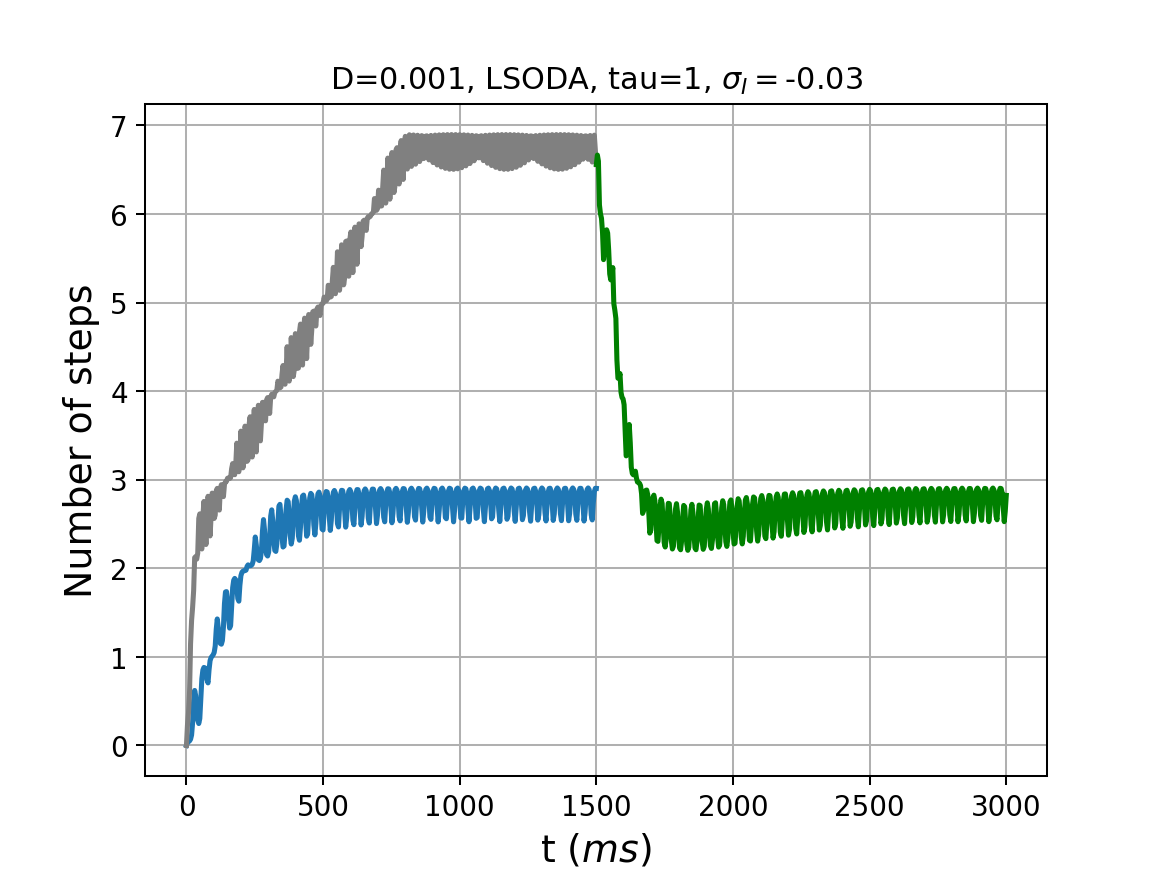

<IPython.core.display.Javascript object>


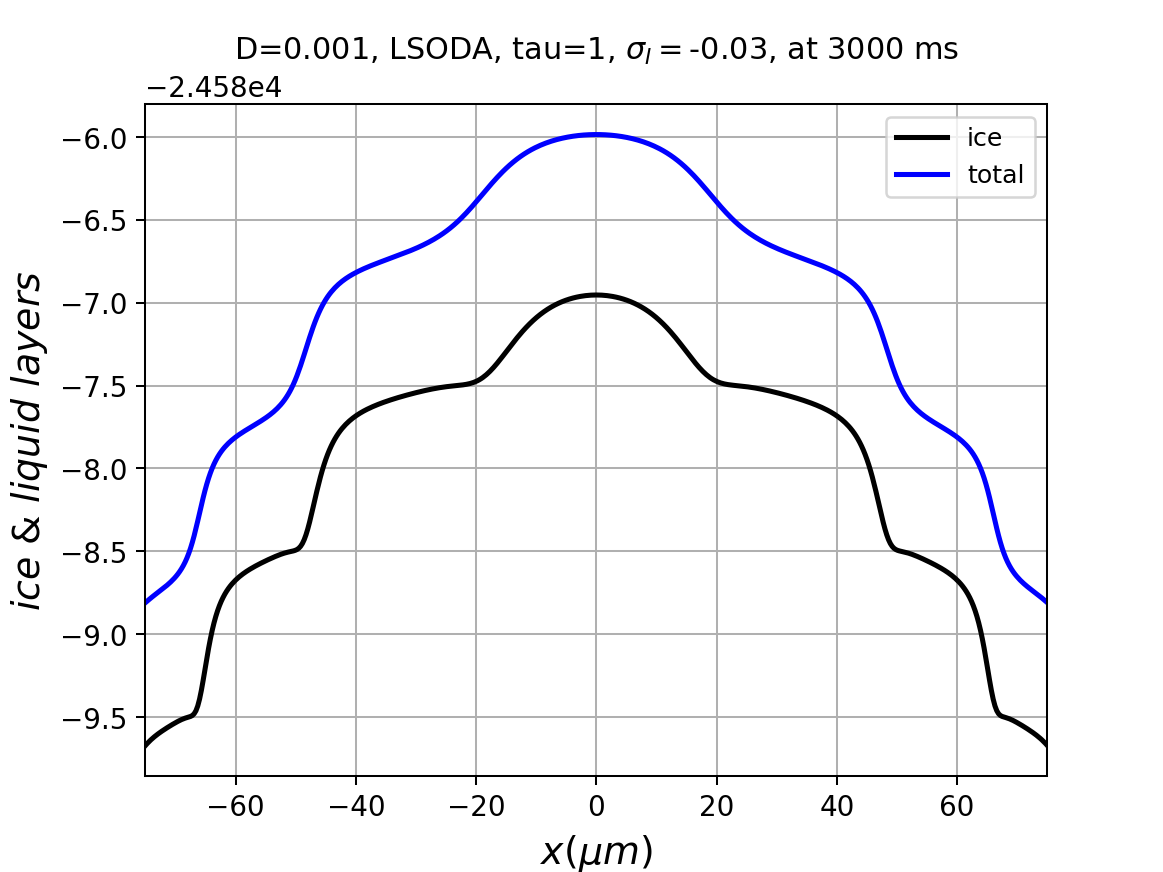

In [46]:
if Iwantperturbation2:
    
    # Plot number of steps over time
    plt.figure()
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    plt.plot(tkeep_1Darr/1e3,f,lw=linewidth)
    
    f = np.max(Ntotkeep_perturbed,axis=1) - np.min(Ntotkeep_perturbed,axis=1)
    plt.plot(tkeep_perturbed/1e3,f,lw=linewidth,color='gray')
    
    f = np.max(Ntotkeep_perturbed2,axis=1) - np.min(Ntotkeep_perturbed2,axis=1)
    plt.plot(tkeep_perturbed2/1e3,f,lw=linewidth,color='g')
    
    plt.xlabel(r't ($m s$)',fontsize=fontsize)
    plt.ylabel('Number of steps',fontsize=fontsize)
    plt.title(title)
    plt.grid('on')
    
    # Plot ice and total
    itime = -1
    plt.figure()
    plt.plot(x-xmid, Nicekeep_perturbed2[itime,:], 'k', label='ice', lw=linewidth)
    plt.plot(x-xmid, Ntotkeep_perturbed2[itime,:], 'b', label='total', lw=linewidth)
    plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
    plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
    plt.xlim([-xmid, xmid])
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.legend()
    plt.title(title+', at '+str(int(tkeep_perturbed2[itime]/1e3))+' ms')
    plt.grid('on')

In [24]:
# # Calculate sigma_m
# sigma_m = ds.getsigma_m(NQLLkeep_1D[itime,:],Nbar,Nstar,sigmaI,sigma0)
# # sigma_m_perturbed = ds.getsigma_m(NQLLkeep_1D[itime,:],Nbar,Nstar,sigmaI_perturbed,sigma0)
# sigma_m_perturbed = ds.getsigma_m(NQLLkeep_perturbed[itime,:],Nbar,Nstar,sigmaI_perturbed,sigma0)
# mysigma_m = getsigma_m(NQLLkeep_1D[itime,:],Nbar,Nstar,sigmaI,sigma0,.997,-.0002)


# # Plot differences in sigma_m
# plt.figure()
# plt.plot(x-xmid, sigma_m_perturbed-sigma_m, lw=linewidth,label='perturbed - original')
# plt.plot(x-xmid, mysigma_m-sigma_m, lw=linewidth,label='scaled - original')
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$\sigma_m$',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.title(title+', at '+str(int(tkeep_1Darr[itime]/1e3))+' ms')
# plt.grid('on')
# plt.legend()

# # Plot sigma_m
# plt.figure()
# plt.plot(x-xmid, sigma_m, lw=linewidth,label='original')
# plt.plot(x-xmid, sigma_m_perturbed, 'b', lw=linewidth,label='perturbed')
# plt.plot(x-xmid, mysigma_m, '--', lw=linewidth, label='scaled')
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$\sigma_m$',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.title(title+', at '+str(int(tkeep_1Darr[itime]/1e3))+' ms')
# plt.grid('on')
# plt.legend()


In [25]:
# Iwantperturbations = True
# if Iwantperturbations:
    
#     sigmaIcorner = 0.275 # Must be bigger than sigma0 to get growth
#     # Overlying supersaturation
#     sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
#     sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
#     # sigmaIstyle = 'sinusoid'
#     sigmaIstyle = 'parabolic'
#     if sigmaIstyle=='sinusoid':
#         sigmaI_perturbed = sigmaI_sinusoid
#     elif sigmaIstyle=='parabolic':
#         sigmaI_perturbed = sigmaI_parabolic
#     else:
#         print('bad choice')
#     plt.figure()
#     plt.plot(x-xmid, sigmaI_parabolic, '--', \
#              x-xmid, sigmaI_perturbed, \
#              lw=linewidth)
#     plt.xlim([-xmid,xmid])
#     plt.legend(['starting','perturbed'])
#     plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
#     plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
#     plt.grid('on')

#     # Make a copy of the last state
#     Ntot_init_perturbed = Ntotlast
#     NQLL_init_perturbed = ds.getNQLL(Ntot_init_perturbed,Nstar,Nbar)
#     Nice_init_perturbed = Ntot_init_perturbed - NQLL_init_perturbed
#     ylast = np.array([NQLL_init_perturbed, Ntot_init_perturbed])
#     ylast = np.reshape(ylast,2*nx)
    
#     # Accumulators
#     tkeep_perturbed = []
#     ykeep_perturbed = []
#     tlast = t_init

#     # Decide how long to integrate
#     countermax_perturbed = 50
#     counter = 0
#     layer = 0
#     ttot = 0.0
    
#     # Time steps
#     t_init = 0.0
#     deltat_perturbed = deltat_0D*10
#     tinterval = [t_init, t_init+deltat_perturbed]
#     print('deltat_perturbed =', deltat_perturbed)
        
#     while True:
#         # Integrate up to next time step
#         sol = solve_ivp(ds.f1d_solve_ivp, tinterval, ylast, args=(scalar_params,sigmaI_perturbed),rtol=1e-12,method=odemethod)
#         ylast = sol.y[:,-1]
#         tlast += deltat_1D

#         # Stuff into keeper arrays
#         ykeep_perturbed.append(ylast)
#         tkeep_perturbed.append(tlast)

#         # Make some local copies
#         ttot += deltat_1D

#         # Update counters and see whether to break
#         NQLLlast_perturbed, Ntotlast_perturbed = np.reshape(ylast,(2,nx))
#         minpoint = min(Ntotlast_perturbed)
#         maxpoint = max(Ntotlast_perturbed)
#         #print(counter, int(Ntotlast_perturbed[0]), maxpoint-minpoint)
#         counter += 1
#         if counter > countermax_perturbed-1:
#                 break
                
#     # Plot NQLL (last and perturbed)
#     plt.figure()
#     plt.plot(x-xmid, NQLLlast_perturbed, 'r', label='Perturbed', lw=linewidth)
#     plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
#     plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
#     plt.xlim([-xmid, xmid])
#     rcParams['xtick.labelsize'] = ticklabelsize 
#     rcParams['ytick.labelsize'] = ticklabelsize
#     plt.grid('on')
#     plt.title('After '+str(counter)+' iterations')

# #     # Plot ice and total (last and perturbed)
# #     Nicelast_perturbed = Ntotlast_perturbed - NQLLlast_perturbed
# #     plt.figure()
# #     plt.plot(x-xmid, Nicelast_perturbed, 'k--', lw=linewidth)
# #     plt.plot(x-xmid, Ntotlast_perturbed, 'b--', lw=linewidth)
# #     plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# #     plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
# #     plt.xlim([-xmid, xmid])
# #     rcParams['xtick.labelsize'] = ticklabelsize 
# #     rcParams['ytick.labelsize'] = ticklabelsize
# #     plt.grid('on')
# #     plt.title('After '+str(counter)+' iterations')


### Sinusoidal perturbations to steady state
I wrote this code, and it works, I'm just not sure what we can learn from it.

In [26]:
# mode = 1
# amp = -Nbar/50
# Ntot_perturbation = np.cos((x-xmid)/xmid*np.pi*mode)*amp
# Ntot_init_perturbed = Ntotlast + Ntot_perturbation
# NQLL_init_perturbed = ds.getNQLL(Ntot_init_perturbed,Nstar,Nbar)
# Nice_init_perturbed = Ntot_init_perturbed - NQLL_init_perturbed

# # Plot NQLL (last and perturbed)
# plt.figure()
# plt.plot(x-xmid, NQLLlast, 'b', label='last NQLL', lw=linewidth)
# plt.plot(x-xmid, NQLL_init_perturbed, 'r', label='Perturbed', lw=linewidth)
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.legend()
# plt.grid('on')
# plt.title('Starting perturbed state')

# # # Plot ice and total (last and perturbed)
# # plt.figure()
# # plt.plot(x-xmid, Nicelast, 'k', label='ice', lw=linewidth)
# # plt.plot(x-xmid, Ntotlast, 'b', label='total', lw=linewidth)
# # plt.plot(x-xmid, Nice_init_perturbed, 'k--', lw=linewidth)
# # plt.plot(x-xmid, Ntot_init_perturbed, 'b--', lw=linewidth)
# # plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# # plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
# # plt.xlim([-xmid, xmid])
# # rcParams['xtick.labelsize'] = ticklabelsize 
# # rcParams['ytick.labelsize'] = ticklabelsize
# # plt.legend()
# # plt.grid('on')
# # plt.title('Starting perturbed state')

# Iwantperturbations = True
# if Iwantperturbations:

#     # Set up initial condidions
#     ylast = np.array([NQLL_init_perturbed, Ntot_init_perturbed])
#     ylast = np.reshape(ylast,2*nx)
    
#     # Accumulators
#     tkeep_perturbed = []
#     ykeep_perturbed = []
#     tlast = t_init

#     # Decide how long to integrate
#     countermax_perturbed = 50
#     counter = 0
#     layer = 0
#     ttot = 0.0
        
#     while True:
#         # Integrate up to next time step
#         sol = solve_ivp(ds.f1d_solve_ivp, tinterval, ylast, args=(scalar_params,sigmaI),rtol=1e-12,method=odemethod)
#         ylast = sol.y[:,-1]
#         tlast += deltat_1D

#         # Stuff into keeper arrays
#         ykeep_perturbed.append(ylast)
#         tkeep_perturbed.append(tlast)

#         # Make some local copies
#         ttot += deltat_1D

#         # Update counters and see whether to break
#         NQLLlast_perturbed, Ntotlast_perturbed = np.reshape(ylast,(2,nx))
#         minpoint = min(Ntotlast_perturbed)
#         maxpoint = max(Ntotlast_perturbed)
#         #print(counter, int(Ntotlast_perturbed[0]), maxpoint-minpoint)
#         counter += 1
#         if counter > countermax_perturbed-1:
#                 break
#     # Plot NQLL (last and perturbed)
#     plt.figure()
#     plt.plot(x-xmid, NQLLlast_perturbed, 'r', label='Perturbed', lw=linewidth)
#     plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
#     plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
#     plt.xlim([-xmid, xmid])
#     rcParams['xtick.labelsize'] = ticklabelsize 
#     rcParams['ytick.labelsize'] = ticklabelsize
#     plt.grid('on')
#     plt.title('After '+str(counter)+' iterations')

# #     # Plot ice and total (last and perturbed)
# #     Nicelast_perturbed = Ntotlast_perturbed - NQLLlast_perturbed
# #     plt.figure()
# #     plt.plot(x-xmid, Nicelast_perturbed, 'k--', lw=linewidth)
# #     plt.plot(x-xmid, Ntotlast_perturbed, 'b--', lw=linewidth)
# #     plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# #     plt.ylabel(r'$ice \ & \ liquid \ layers$',fontsize=fontsize)
# #     plt.xlim([-xmid, xmid])
# #     rcParams['xtick.labelsize'] = ticklabelsize 
# #     rcParams['ytick.labelsize'] = ticklabelsize
# #     plt.grid('on')
# #     plt.title('After '+str(counter)+' iterations')


### The cell below is just backup for parameters, and allows some exploration (but not part of the simulation)

In [27]:
# # Exploring the D^.5 dependence of lambda
# plt.figure()
# Dlist = np.array([1e-3, 5e-4, 2e-4])/2e-4
# nsteadystatelist = np.array([7,10,16])
# lambdalist = 75/nsteadystatelist
# plt.plot(Dlist**.5,lambdalist,'o')
# plt.grid(True)
# plt.xlabel(r'$D^{1/2}$',fontsize=fontsize)
# plt.ylabel(r'$\lambda$',fontsize=fontsize)

<IPython.core.display.Javascript object>


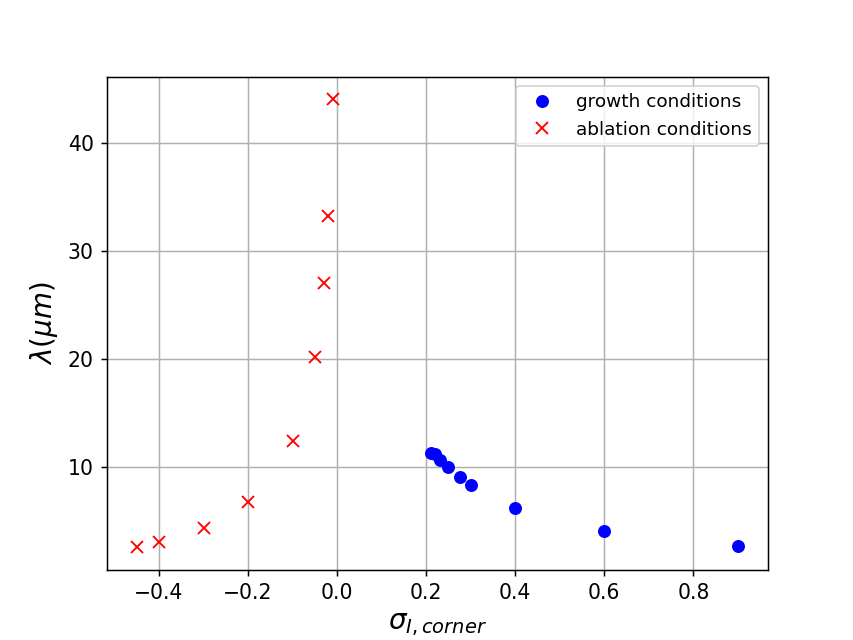

<IPython.core.display.Javascript object>


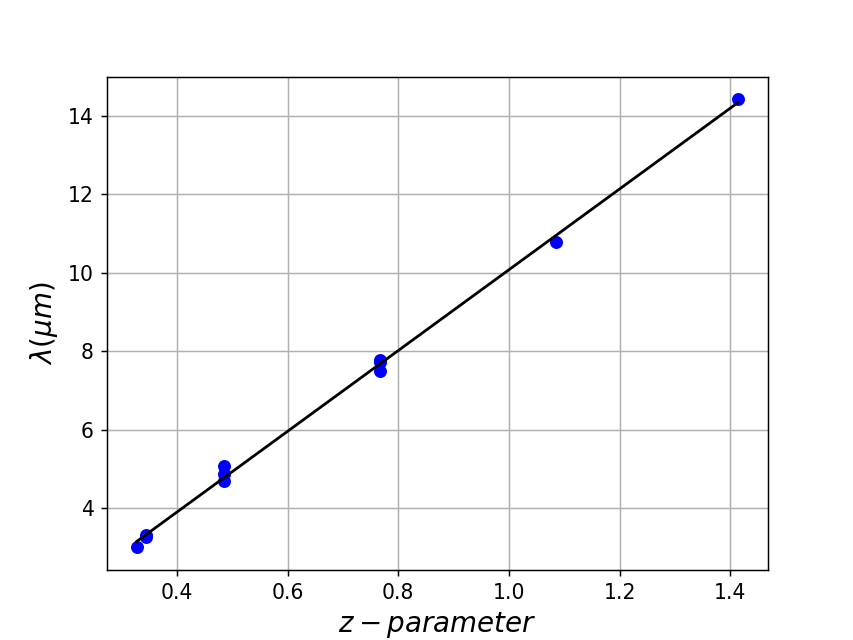

In [63]:
# Exploring the dependence of lambda on parameters
sigmaIcorner_growth = np.array([
0.900,
0.600,
0.400,
0.300,
0.275,
0.250,
0.230,
0.220,
0.210])
lambda_growth = np.array([
2.7,
4.1,
6.2,
8.4,
9.1,
10.0,
10.7,
11.2,
11.3])
sigmaIcorner_ablate = np.array([
-0.010,
-0.020,
-0.030,
-0.050,
-0.100,
-0.200,
-0.300,
-0.400,
-0.450])
lambda_ablate = np.array([
44.1,
33.3,
27.1,
20.2,
12.4,
6.8,
4.4,
3.1,
2.6])

plt.figure()
plt.plot(sigmaIcorner_growth, lambda_growth,'o', color='b', label='growth conditions')
plt.plot(sigmaIcorner_ablate, lambda_ablate, 'x', color='r', label='ablation conditions')
plt.xlabel(r'$\sigma_{I,corner}$',fontsize=fontsize)
plt.ylabel(r'$\lambda (\mu m)$',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')
plt.legend()

zparm_growth = np.array([
0.327,
0.343,
0.343,
0.485,
0.485,
0.485,
0.767,
0.767,
0.767,
1.085,
1.414])
lambda_zparm_growth = np.array([
3.01,
3.28,
3.33,
4.69,
4.87,
5.07,
7.50,
7.73,
7.79,
10.78,
14.42])

plt.figure()
plt.plot(zparm_growth, lambda_zparm_growth,'o', color='b')
plt.plot(zparm_growth, 10.282*zparm_growth-0.2053,color='k')
plt.xlabel(r'$z-parameter$',fontsize=fontsize)
plt.ylabel(r'$\lambda (\mu m)$',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid('on')

In [29]:
# # The time required for an initial gaussian to diffuse
# layer_growth_rate = growthrate_0D/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
# t = 1/layer_growth_rate; print('Time to add a layer =', t)
# t = 2.5**2/D; print('Time to diffuse across a terrace =', t)
# t = deltax**2/D; print('Time for equilibration across dx =', t)
# t = 0.001; print('Time for ice-QLL equilibration =', t)

# # How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
# D_old = 2e-6
# D_new = D_old/50**2*100**2; print(D_new)

# # Computing the kinetic deposition velocity ... roughly, 260 
# M = 18 # g/mol
# T = 260 # K
# NA = 6.02e23
# m = M/NA; print(m,'mass of a molecule of water, grams/mol')
# m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
# R = 8.314 # J/K-mol
# k = R/NA; print(k,"Boltzmann's constant, J/K")

# Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
# V_gas = R*T/Pvap # Must be in m^3
# V_gas *= (10/1)**3; print(V_gas, 'Liters') 
# V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
# c_sat = 1/V_gas # mol/cm^3
# c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

# c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
# V_solid = 1/c_solid # cm^3/g

# V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
# c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

# sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
# nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
# nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# # Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
# M = 18 # g/mol
# T = 240 # K
# NA = 6.02e23
# m = M/NA; print(m,'mass of a molecule of water, grams/mol')
# m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
# R = 8.314 # J/K-mol
# k = R/NA; print(k,"Boltzmann's constant, J/K")

# Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
# V_gas = R*T/Pvap # Must be in m^3
# V_gas *= (10/1)**3; print(V_gas, 'Liters') 
# V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
# c_sat = 1/V_gas # mol/cm^3
# c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

# c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
# V_solid = 1/c_solid # cm^3/g

# V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
# c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

# sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
# nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
# nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# # Gladich et al recommendation
# D_Gladich = 0.16e-9 # m^2/s
# D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)

In [30]:
# def run_f1d(NQLL_init_1D,Ntot_init_1D,times,scalar_params,sigmaI,odemethod):
#     # Call the ODE solver
#     nt = len(times)
#     nx = len(NQLL_init_1D)
#     ylast = np.array([NQLL_init_1D,Ntot_init_1D])
#     ylast = np.reshape(ylast,2*nx)
#     ykeep_1D = [ylast]

#     for i in range(0,nt-1):

#         # Specify the time interval of this step
#         tinterval = [times[i],times[i+1]]
        
#         # Integrate up to next time step
#         sol = solve_ivp(ds.f1d_solve_ivp, tinterval, ylast, args=(scalar_params,sigmaI),rtol=1e-12,method=odemethod)
#         ylast = sol.y[:,-1]
        
#         # Stuff into keeper arrays
#         ykeep_1D.append(ylast)
        
#         # Progress reporting
#         print(i/nt*100,'% done')

#     ykeep_1D = np.array(ykeep_1D, np.float64)
#     ykeep_1Darr = np.array(ykeep_1D, np.float64)
#     ykeep_1Darr_reshaped = np.reshape(ykeep_1Darr,(nt,2,nx))
#     Ntotkeep_1D = ykeep_1Darr_reshaped[:,1,:]
#     NQLLkeep_1D = ykeep_1Darr_reshaped[:,0,:]
#     return Ntotkeep_1D, NQLLkeep_1D